<center><h1>DSCI-552 HOMEWORK 7</h1><center>
<br>
<center><font size="4"></font></center>
<center><font size="3"><strong>Mason(Mohan) Xing</font></center>
<center><font size="3"><strong>USCID:6880083372</font></center>

In [29]:
# import dependencies
# import warnings
# warnings.filterwarnings("ignore")
import glob
import os
import urllib
import tarfile
import pickle
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
from sklearn.cluster import KMeans
from skimage import io
from skimage.color import rgb2gray

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam


# check if GPU is mounted
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)
# check the environment
print (os.environ['CONDA_DEFAULT_ENV'])

['/device:CPU:0', '/device:GPU:0']
Num GPUs Available:  1
TensorFlow version: 2.7.0
dsci552


# 2. (Deep) CNNs for Image Colorization

## (a) This assignment uses a convolutional neural network for image colorization which turns a grayscale image to a colored image. 
By converting an image to grayscale,we loose color information, so converting a grayscale image back to a colored version is not an easy job. We will use the CIFAR-10 dataset. Downolad the dataset from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz.

In [2]:
# # download original dataset
# url = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
# datafile = "../data/CIFAR-10/cifar-10-python.tar.gz"
# urllib.request.urlretrieve(url, datafile)
# # open file
# file = tarfile.open(datafile)
# # extracting file
# file.extractall('../data/CIFAR-10/')
# file.close()
# os.remove(datafile)

In [3]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
folder = "../data/CIFAR-10/cifar-10-batches-py"
X_train_data_temp = []
y_train_data_temp = []
X_test_data_temp = []
y_test_data_temp = []

for file in os.listdir(folder):
    if file.endswith(".meta") or file.endswith(".html"):
        pass
    elif "test_batch" in file:
        test_data_temp = unpickle(folder + "/" + file)
        X_test_data_temp.extend(test_data_temp[b'data'])
        y_test_data_temp.extend(test_data_temp[b'labels'])
    else:
        train_temp_data = unpickle(folder + "/" + file)
        X_train_data_temp.extend(train_temp_data[b'data'])
        y_train_data_temp.extend(train_temp_data[b'labels'])
        
    X_tr_data_temp = np.array(X_train_data_temp)
    y_tr_data_temp = np.array(y_train_data_temp)
    X_ts_data_temp = np.array(X_test_data_temp)
    y_ts_data_temp = np.array(y_test_data_temp)

In [5]:
print(X_tr_data_temp.shape)
print(y_tr_data_temp.shape)
print(X_ts_data_temp.shape)
print(y_ts_data_temp.shape)

(50000, 3072)
(50000,)
(10000, 3072)
(10000,)


## (b) From the train and test dataset, extract the class birds. We will focus on this class, which has 6000 members.
ref: https://akshaysin.github.io/cifar_cnn.html<br>
ref: https://github.com/deep-diver/CIFAR10-img-classification-tensorflow/blob/master/CIFAR10_image_classification.ipynb<br>

In [6]:
X_temp = np.vstack((X_tr_data_temp, X_ts_data_temp))
y_temp = np.hstack((y_tr_data_temp, y_ts_data_temp))

In [7]:
# get the index of bird samples
X_bird_temp = X_temp[np.where(y_temp == 2)]
y_bird_temp = y_temp[np.where(y_temp == 2)]

# get the correct image array
X_bird = X_bird_temp.reshape(X_bird_temp.shape[0], 3, 32, 32).transpose(0, 2, 3, 1)
print(X_bird.shape)

(6000, 32, 32, 3)


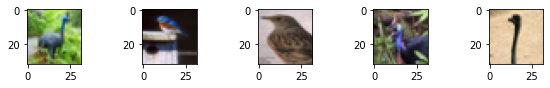

In [8]:
fig, axes = plt.subplots(1, 5, figsize=(10, 1))
for i in range(5):
    axes[i].imshow(X_bird[i])
plt.show()

## (c) Those 6000 images have 6000 X 32 X 32 pixels. 
Choose at least 10% of the pixels randomly. It is strongly recommended that you choose a large number or all of the pixels. You will have between P = 614400 and P = 6144000 pixels. Each pixel is an RGB vector with three elements.

In [9]:
pixel_array = X_bird.reshape(-1,3)
select_ratio = 1
number_of_rows = pixel_array.shape[0]
np.random.seed(42)
random_indices = np.random.choice(number_of_rows, size=int(number_of_rows*select_ratio), replace=False)
p = pixel_array[random_indices]

## (d) Run k-means clustering on the P vectors using k = 4. 
The centers of the clusters will be your main colors. Convert the colored images to k-color images by converting each pixel's value to the closest main color in terms of Euclidean distance. These are the outputs of your network, whose each pixel falls in one of those k classes.

### - Use K means Color

In [10]:
%%time
km = KMeans(n_clusters=4, n_init=10, random_state=42)
km.fit(p)

Wall time: 35 s


KMeans(n_clusters=4, random_state=42)

[[156 156 136]
 [109 109  83]
 [206 212 211]
 [ 49  50  38]]


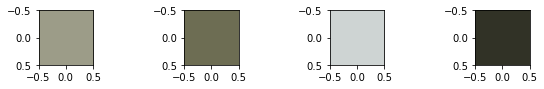

In [11]:
# check center and center color
center = km.cluster_centers_.astype(np.uint8())
print(center)

fig, axes = plt.subplots(1, 4, figsize=(10, 1))
for i in range(4):
    axes[i].imshow([[(center[i][0], center[i][1], center[i][2])]])
plt.show()

In [12]:
cluster_label = km.predict(pixel_array)
array_kcolor = pixel_array.copy()
for i in range(pixel_array.shape[0]):
    array_kcolor[i] = center[cluster_label[i]]
X_kcolor = np.reshape(array_kcolor, X_bird.shape)
print(X_kcolor.shape)

(6000, 32, 32, 3)


### - Use Suggested Color

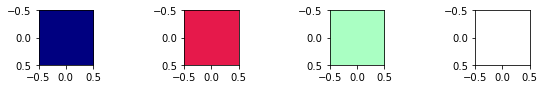

In [13]:
k_color = np.array([[0,0,128], [230,25,75], [170,255,195], [255,255,255]])
fig, axes = plt.subplots(1, 4, figsize=(10, 1))
for i in range(4):
    axes[i].imshow([[(k_color[i][0], k_color[i][1], k_color[i][2])]])
plt.show()

In [14]:
# set cluster center to suggested colors
# km2 = KMeans(n_clusters=4, init=k_color, n_init=1, max_iter=1, random_state=42)
# colorlabel = km2.fit_predict(pixel_array)

In [15]:
array_kcolor = pixel_array.copy()
for i in range(pixel_array.shape[0]):
    array_kcolor[i] = k_color[cluster_label[i]]
X_kcolor_suggest = np.reshape(array_kcolor, X_bird.shape)
print(X_kcolor_suggest.shape)

(6000, 32, 32, 3)


## (e) Use any tool (e.g., openCV or scikit-learn) to obtain grayscale 32X32X1 images from the original 32X32X3 images. The grayscale images are inputs of your network

In [16]:
X_grayscale = rgb2gray(X_bird)
print(X_grayscale.shape)

(6000, 32, 32)


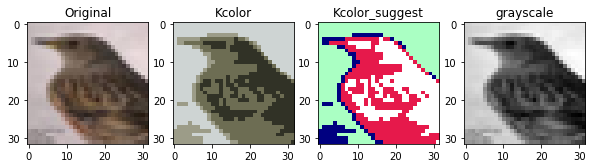

In [17]:
fig, axes = plt.subplots(1, 4, figsize=(10, 3))
axes[0].imshow(X_bird[2])
axes[1].imshow(X_kcolor[2])
axes[2].imshow(X_kcolor_suggest[2])
axes[3].imshow(X_grayscale[2],cmap="gray")

axes[0].set_title("Original")
axes[1].set_title("Kcolor")
axes[2].set_title("Kcolor_suggest")
axes[3].set_title("grayscale")
plt.show()

## (f) Set up a deep convolutional neural network with two convolution layers (or more) and two (or more) MLP layers.
ref: https://dingyan89.medium.com/calculating-parameters-of-convolutional-and-fully-connected-layers-with-keras-186590df36c6<br>
ref: https://maet3608.github.io/nuts-ml/tutorial/cifar10_example.html

In [18]:
X_train = X_grayscale[:5000]
X_test = X_grayscale[5000:]
onehotlabel = to_categorical(cluster_label)
y = onehotlabel.reshape(X_bird.shape[0], X_bird.shape[1], X_bird.shape[2], onehotlabel.shape[1])
y_train = y[:5000]
y_test = y[5000:]
print("X_train Shape: " , X_train.shape)
print("y_train Shape: " ,y_train.shape)
print("X_test Shape: " , X_test.shape)
print("y_test Shape: " ,y_test.shape)

X_train Shape:  (5000, 32, 32)
y_train Shape:  (5000, 32, 32, 4)
X_test Shape:  (1000, 32, 32)
y_test Shape:  (1000, 32, 32, 4)


In [19]:
CNN_model = Sequential()
# convolutional 
CNN_model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', input_shape=(32,32,1), activation='relu'))
CNN_model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
CNN_model.add(Dropout(0.2))
CNN_model.add(Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='relu'))
CNN_model.add(Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
CNN_model.add(Dropout(0.2))

# MLP 
CNN_model.add(Flatten())
CNN_model.add(Dense(4096, activation='relu'))
CNN_model.add(Dropout(0.5))
CNN_model.add(Dense(4096, activation='relu'))
CNN_model.add(Reshape((32,32,4)))
CNN_model.add(Activation('softmax'))

In [20]:
print(CNN_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        51264     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        102464    
                                                        

In [21]:
#complie the model
CNN_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
# delete all previous models
model_path = "../model/CNN/"
for f in os.listdir(model_path):
    os.remove(os.path.join(model_path, f))
    
model_file = model_path + "{epoch:02d}-val_acc-{val_accuracy:.4f}-val_loss-{val_loss:.4f}.hdf5"
#ModelCheckpoint
checkPoint = ModelCheckpoint(model_file, monitor="val_accuracy", verbose=1, save_best_only=True, 
                             save_weights_only=False, mode='max')
#EarlyStopping
stopPoint = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=20, verbose=1, mode='auto')
#ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=0.0001, cooldown=2)

In [23]:
class CustomCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, test_data):
        self.test_data = test_data
    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        test_loss.append(loss)
        test_acc.append(acc)
        print('\nTest_loss: {:.4f} - Test_accuracy: {:.4f}\n'.format(loss, acc))

In [24]:
callback = [checkPoint, stopPoint, CustomCallback((X_test, y_test))]

In [25]:
test_loss =[]
test_acc = []
hist = CNN_model.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=100, callbacks=callback)

Epoch 1/100
121/125 [============================>.] - ETA: 0s - loss: 1.2893 - accuracy: 0.3776
Epoch 00001: val_accuracy improved from -inf to 0.48670, saving model to ../model/CNN\01-val_acc-0.4867-val_loss-1.1309.hdf5

Test_loss: 1.1339 - Test_accuracy: 0.4805

125/125 [==============================] - 3s 10ms/step - loss: 1.2839 - accuracy: 0.3811 - val_loss: 1.1309 - val_accuracy: 0.4867
Epoch 2/100
120/125 [===========================>..] - ETA: 0s - loss: 1.0401 - accuracy: 0.5378
Epoch 00002: val_accuracy improved from 0.48670 to 0.55420, saving model to ../model/CNN\02-val_acc-0.5542-val_loss-1.0092.hdf5

Test_loss: 1.0185 - Test_accuracy: 0.5508

125/125 [==============================] - 1s 8ms/step - loss: 1.0403 - accuracy: 0.5376 - val_loss: 1.0092 - val_accuracy: 0.5542
Epoch 3/100
121/125 [============================>.] - ETA: 0s - loss: 0.9580 - accuracy: 0.5795
Epoch 00003: val_accuracy improved from 0.55420 to 0.59941, saving model to ../model/CNN\03-val_acc-0.599


Test_loss: 0.7476 - Test_accuracy: 0.6907

125/125 [==============================] - 1s 6ms/step - loss: 0.4632 - accuracy: 0.8078 - val_loss: 0.7459 - val_accuracy: 0.6906
Epoch 22/100
116/125 [==========================>...] - ETA: 0s - loss: 0.4478 - accuracy: 0.8148
Epoch 00022: val_accuracy improved from 0.69114 to 0.69294, saving model to ../model/CNN\22-val_acc-0.6929-val_loss-0.7624.hdf5

Test_loss: 0.7640 - Test_accuracy: 0.6917

125/125 [==============================] - 1s 8ms/step - loss: 0.4487 - accuracy: 0.8144 - val_loss: 0.7624 - val_accuracy: 0.6929
Epoch 23/100
125/125 [==============================] - ETA: 0s - loss: 0.4343 - accuracy: 0.8211
Epoch 00023: val_accuracy improved from 0.69294 to 0.69346, saving model to ../model/CNN\23-val_acc-0.6935-val_loss-0.7406.hdf5

Test_loss: 0.7428 - Test_accuracy: 0.6920

125/125 [==============================] - 1s 8ms/step - loss: 0.4343 - accuracy: 0.8211 - val_loss: 0.7406 - val_accuracy: 0.6935
Epoch 24/100
115/125 [=

116/125 [==========================>...] - ETA: 0s - loss: 0.2929 - accuracy: 0.8814
Epoch 00043: val_accuracy did not improve from 0.70458

Test_loss: 0.7487 - Test_accuracy: 0.7037

125/125 [==============================] - 1s 6ms/step - loss: 0.2937 - accuracy: 0.8811 - val_loss: 0.7502 - val_accuracy: 0.7035
Epoch 44/100
114/125 [==========================>...] - ETA: 0s - loss: 0.2877 - accuracy: 0.8835
Epoch 00044: val_accuracy improved from 0.70458 to 0.70484, saving model to ../model/CNN\44-val_acc-0.7048-val_loss-0.7478.hdf5

Test_loss: 0.7518 - Test_accuracy: 0.7031

125/125 [==============================] - 1s 8ms/step - loss: 0.2887 - accuracy: 0.8830 - val_loss: 0.7478 - val_accuracy: 0.7048
Epoch 45/100
115/125 [==========================>...] - ETA: 0s - loss: 0.2823 - accuracy: 0.8858
Epoch 00045: val_accuracy did not improve from 0.70484

Test_loss: 0.7564 - Test_accuracy: 0.7027

125/125 [==============================] - 1s 6ms/step - loss: 0.2825 - accuracy: 0.885

118/125 [===========================>..] - ETA: 0s - loss: 0.2303 - accuracy: 0.9078
Epoch 00066: val_accuracy improved from 0.70747 to 0.70757, saving model to ../model/CNN\66-val_acc-0.7076-val_loss-0.7735.hdf5

Test_loss: 0.7730 - Test_accuracy: 0.7040

125/125 [==============================] - 1s 8ms/step - loss: 0.2303 - accuracy: 0.9078 - val_loss: 0.7735 - val_accuracy: 0.7076
Epoch 67/100
119/125 [===========================>..] - ETA: 0s - loss: 0.2287 - accuracy: 0.9087
Epoch 00067: val_accuracy did not improve from 0.70757

Test_loss: 0.7569 - Test_accuracy: 0.7052

125/125 [==============================] - 1s 6ms/step - loss: 0.2295 - accuracy: 0.9083 - val_loss: 0.7543 - val_accuracy: 0.7072
Epoch 68/100
115/125 [==========================>...] - ETA: 0s - loss: 0.2262 - accuracy: 0.9100
Epoch 00068: val_accuracy improved from 0.70757 to 0.70831, saving model to ../model/CNN\68-val_acc-0.7083-val_loss-0.7598.hdf5

Test_loss: 0.7587 - Test_accuracy: 0.7066

125/125 [=====

116/125 [==========================>...] - ETA: 0s - loss: 0.2006 - accuracy: 0.9210
Epoch 00089: val_accuracy improved from 0.71067 to 0.71068, saving model to ../model/CNN\89-val_acc-0.7107-val_loss-0.7584.hdf5

Test_loss: 0.7630 - Test_accuracy: 0.7089

125/125 [==============================] - 1s 9ms/step - loss: 0.2009 - accuracy: 0.9209 - val_loss: 0.7584 - val_accuracy: 0.7107
Epoch 90/100
125/125 [==============================] - ETA: 0s - loss: 0.1985 - accuracy: 0.9218
Epoch 00090: val_accuracy did not improve from 0.71068

Test_loss: 0.7602 - Test_accuracy: 0.7059

125/125 [==============================] - 1s 6ms/step - loss: 0.1985 - accuracy: 0.9218 - val_loss: 0.7563 - val_accuracy: 0.7072
Epoch 91/100
116/125 [==========================>...] - ETA: 0s - loss: 0.1973 - accuracy: 0.9224
Epoch 00091: val_accuracy improved from 0.71068 to 0.71088, saving model to ../model/CNN\91-val_acc-0.7109-val_loss-0.7683.hdf5

Test_loss: 0.7699 - Test_accuracy: 0.7088

125/125 [=====

### Plot training, (validation), and test errors in each epoch.

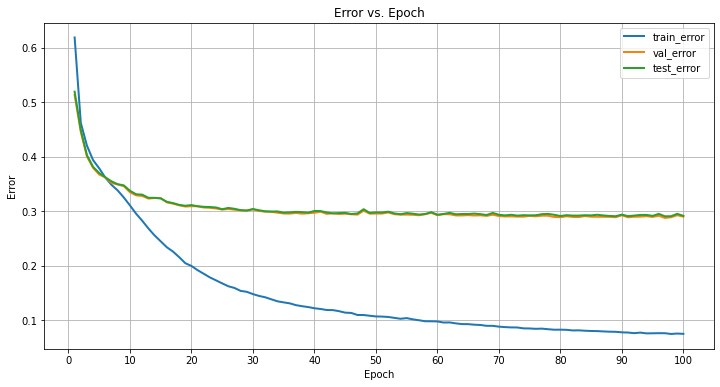

In [27]:
train_errors = [1-x for x in hist.history['accuracy']]
validation_errors = [1-x for x in hist.history['val_accuracy']]
test_errors = [1-x for x in test_acc]

# plot loss curves
epoch_num = list(range(1,101))
plt.figure(figsize=(12, 6))
plt.plot(epoch_num, train_errors, label='train_error',linewidth=2)
plt.plot(epoch_num, validation_errors, label='val_error',linewidth=2)
plt.plot(epoch_num, test_errors, label='test_error',linewidth=2)
plt.legend(loc="upper right")
plt.xticks(list(range(0,110,10)))
plt.title('Error vs. Epoch')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.grid()
plt.show()

### Report the train and test errors

In [47]:
folder_path = '../model/CNN'
file_type = '\*.hdf5'
files = glob.glob(folder_path + file_type)
max_file = max(files, key=os.path.getctime)

print (max_file)

../model/CNN\97-val_acc-0.7120-val_loss-0.7610.hdf5


In [48]:
loaded_model = load_model(max_file)
y_pred_temp = loaded_model.predict(X_test[:10])
y_pred = np.argmax(y_pred_temp, axis=-1)
y_pred_color = center[y_pred]
y_pred_color_suggest = k_color[y_pred]
print(y_pred_color.shape)
print(y_pred_color_suggest.shape)

(10, 32, 32, 3)
(10, 32, 32, 3)


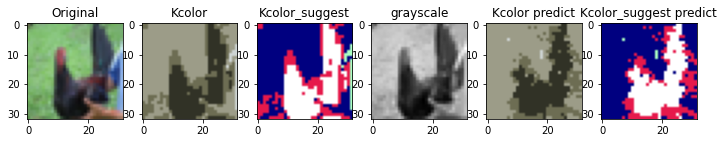

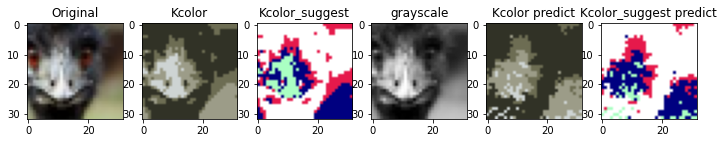

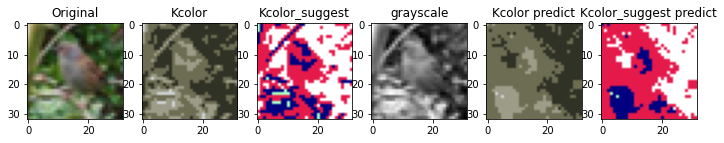

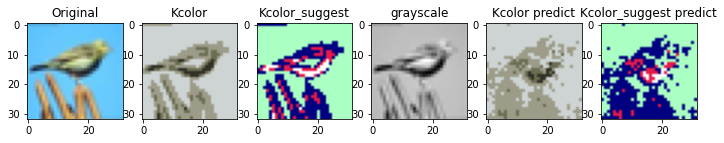

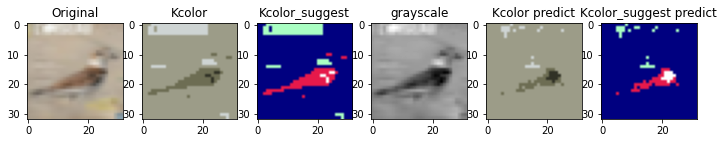

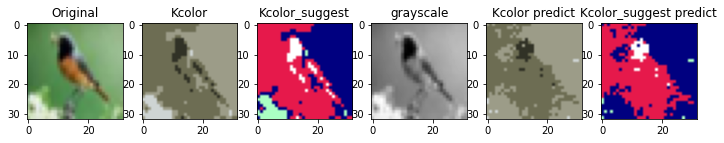

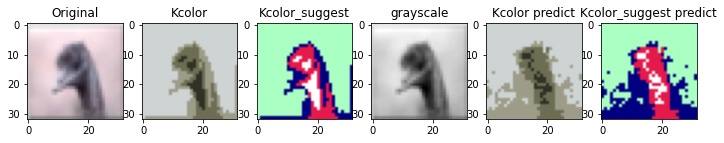

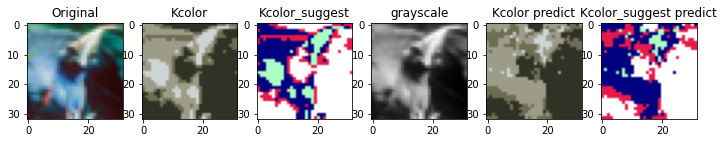

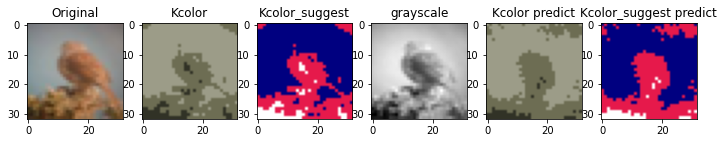

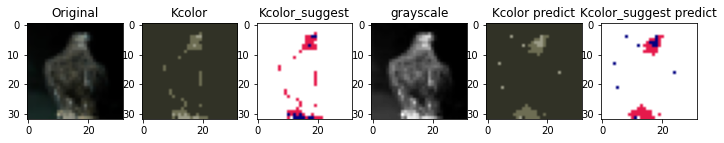

In [56]:
for i in range(10):
    fig, axes = plt.subplots(1, 6, figsize=(12, 6))
    axes[0].imshow(X_bird[i+5000])
    axes[1].imshow(X_kcolor[i+5000])
    axes[2].imshow(X_kcolor_suggest[i+5000])
    axes[3].imshow(X_grayscale[i+5000],cmap="gray")
    axes[4].imshow(y_pred_color[i])
    axes[5].imshow(y_pred_color_suggest[i])
    
    axes[0].set_title("Original")
    axes[1].set_title("Kcolor")
    axes[2].set_title("Kcolor_suggest")
    axes[3].set_title("grayscale")
    axes[4].set_title("Kcolor predict")
    axes[5].set_title("Kcolor_suggest predict")
    plt.show()
    